Import simulator and utilities

In [67]:
from src.base import FDTD2D
from src.detectors import PointDetector
from src.geometries import Rectangle,Circle
from src.sources import PointSource, LineSource

from src.viz import viz2D
from src.utilities import print_setup_info

In [68]:
# convert frequency
f = 1.5e14 #1/s
c = 299792458 #m/s
wavelength = c/f #m
print(wavelength)


1.9986163866666668e-06


In [83]:
params = {
    'backend': 'pytorch',
    'precision': 'float64',
    'nx': 200,
    'ny': 100,
    'time_steps': 3000,
    'dx': 50e-9,
    'dy': 50e-9,
    'polarization': 'TE',
    'use_pml': True,
    'pml_thickness': 20,
    'use_tfsf': False,
    'tfsf_thickness': 10,
    'function': 'sinusoidal',
    'frequency': 2.0e14, #1.5e14,
    'source_type': 'line_source',
    'line_x': 20,
    'line_y1': 40,
    'line_y2': 60,
}

### Testing initializations

In [84]:
sim = FDTD2D(params = params)

Reading configuration from dictionary...


### Set detectors

In [85]:
point_detector = PointDetector("point1", (98, 53))
sim.add_detector(point_detector)

### Set sources

In [86]:
line_source = LineSource(x=sim.line_x, y1=sim.line_y1, y2=sim.line_y2, function=sim.function, frequency=sim.frequency)
sim.add_source(line_source)

### Set geometry

In [87]:
a = 1000e-9
r = 360e-9
w = 1200e-9
d = 1400e-9

In [88]:
print('w_nx',w/sim.dx)
print('a_nx',a/sim.dx)
print('r_nx',r/sim.dx)
print('d_nx',d/sim.dx)

w_nx 24.0
a_nx 20.0
r_nx 7.2
d_nx 28.0


In [89]:
centers_x = [46,66,86,114,134,154]

In [90]:
rectangle = Rectangle(x1=0, y1=37.5, x2=sim.nx, y2=62.5,epsr=13, sigma=0)
sim.add_geometry(rectangle)
sim.update_geometry()

In [91]:
for center in centers_x:    
    sim.add_geometry(Circle(center_x=center, center_y=50, radius=7.2, epsr=1, sigma=0))
    sim.update_geometry()

### Print simulation info

In [92]:
print_setup_info(sim)

Simulation setup information:
nx: 200
ny: 100
time_steps: 3000
time: 0.0
dx: 5e-08
dy: 5e-08
dt: 1.179327168374842e-16
use_pml: True
pml_thickness: 20
frequency: 200000000000000.0
source_type: line_source
line x: 20
line y1: 40
line y2: 60
c: 299792458
epsilon_0: 8.85418782e-12
mu_0: 1.25663706e-06
geometries: [<src.geometries.rectangle.Rectangle object at 0x0000028CBF526520>, <src.geometries.circle.Circle object at 0x0000028CBF518D90>, <src.geometries.circle.Circle object at 0x0000028CC0844460>, <src.geometries.circle.Circle object at 0x0000028CC0AAE4C0>, <src.geometries.circle.Circle object at 0x0000028CC075B220>, <src.geometries.circle.Circle object at 0x0000028CC075BF70>, <src.geometries.circle.Circle object at 0x0000028CC075B7C0>]
sources: [<src.sources.line_source.LineSource object at 0x0000028CBF4DD820>]
detectors: [<src.detectors.point_detector.PointDetector object at 0x0000028CBF526850>]


### Show material distribution

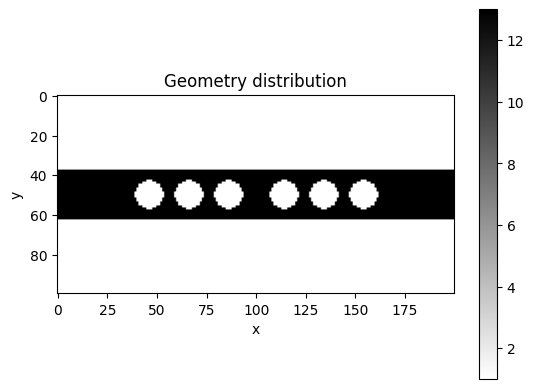

In [93]:
# Visualize permittivity distribution
from matplotlib import pyplot as plt
import numpy as np
plt.imshow(np.transpose(sim.eps_r), cmap='binary')
plt.title('Geometry distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(cmap='binary')
plt.show()

### Simulate

In [95]:
for i in range(1, sim.time_steps):
    sim.simulation_step(i)
    sim.record_detectors(sim.h_field[:,:,2])

### Visualize fields

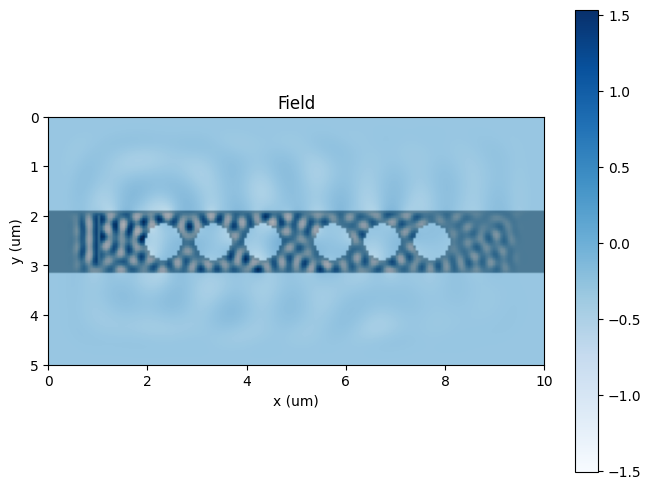

In [96]:
viz2D(sim, sim.h_field[:,:,2])

### Visualize detector

c:\Users\mazzo\anaconda3\envs\fdtd\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Users\mazzo\anaconda3\envs\fdtd\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


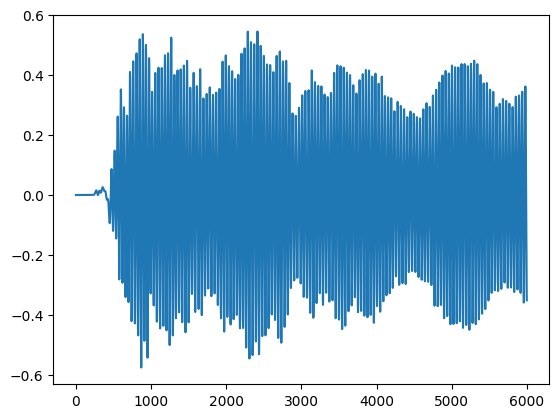

In [97]:
plt.plot(point_detector.recorded_values)

In [10]:
!pip install vtk

In [67]:
import numpy as np
import vtk
from vtk.util import numpy_support

tm_sim.nx, tm_sim.ny = tm_sim.Dz.shape

# Convert the numpy arrays to vtkImageData
energy_data = numpy_support.numpy_to_vtk(tm_sim.Dz.ravel(), deep=True, array_type=vtk.VTK_FLOAT)
geometry_data = numpy_support.numpy_to_vtk(tm_sim.gaz.ravel(), deep=True, array_type=vtk.VTK_UNSIGNED_CHAR)

energy_image = vtk.vtkImageData()
energy_image.SetDimensions(tm_sim.nx, tm_sim.ny, 1)
energy_image.GetPointData().SetScalars(energy_data)

# geometry_image = vtk.vtkImageData()
# geometry_image.SetDimensions(tm_sim.nx, tm_sim.ny, 1)
# geometry_image.GetPointData().SetScalars(geometry_data)

# Create actors for energy and geometry data
energy_mapper = vtk.vtkDataSetMapper()
energy_mapper.SetInputData(energy_image)
energy_actor = vtk.vtkActor()
energy_actor.SetMapper(energy_mapper)

# geometry_mapper = vtk.vtkDataSetMapper()
# geometry_mapper.SetInputData(geometry_image)
# geometry_actor = vtk.vtkActor()
# geometry_actor.SetMapper(geometry_mapper)

# Set up the renderer and render window
renderer = vtk.vtkRenderer()
renderer.AddActor(energy_actor)
# renderer.AddActor(geometry_actor)
renderer.SetBackground(0.2, 0.2, 0.2)

render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)
render_window.SetSize(800, 800)

# Set up the interactor and start the visualization
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(render_window)
interactor.Initialize()
interactor.Start()